In [1]:
import tqdm
import numpy as np
import scipy.stats
import pandas as pd
import sklearn
import sklearn.datasets
from sklearn.feature_selection import mutual_info_regression
import sklearn.covariance
import networkx as nx
import matplotlib.pyplot as plt
% matplotlib inline
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
import seaborn as sns
sns.set_style('ticks')
palette = sns.color_palette("RdBu_r", n_colors=25)
import plotly
plotly.offline.init_notebook_mode(connected=True)

import kliep

In [2]:
def calc_cmi(cov):
    H = np.linalg.slogdet(cov)[1] / 2
    H1 = [np.linalg.slogdet(np.delete(np.delete(cov, [i], axis=0), [i], axis=1))[1] / 2 for i in range(3)]
    H2 = [[np.linalg.slogdet(np.delete(np.delete(cov, [i, j], axis=0), [i, j], axis=1))[1] / 2 for i in range(3)] for j in range(3)]
    cmi = np.array([[H1[i] + H1[j] - (H + H2[i][j]) for i in range(3)] for j in range(3)])
    cmi[np.eye(3, dtype=bool)] = None
    return cmi

In [3]:
def mutual_information_knn_old(X, Y, k=3):
    n_x, d_x = X.shape
    n_y, d_y = Y.shape
    n = n_x
    distances_x = np.linalg.norm(X.reshape([n, -1, d_x]) - X, axis=2)
    distances_y = np.linalg.norm(Y.reshape([n, -1, d_y]) - Y, axis=2)
    distances = np.max([distances_x, distances_y], axis=0)
    epsilons = np.sort(distances, axis=1)[:, k]
    n_x = np.sum(distances_x <= epsilons, axis=0)
    n_y = np.sum(distances_y <= epsilons, axis=0)
    mi = scipy.special.digamma(k) - 1 / k
    mi += scipy.special.digamma(n) - np.mean(scipy.special.digamma(n_x) + scipy.special.digamma(n_y))
    return mi

def mutual_information_knn(X, Y, k=3):
    n_x, d_x = X.shape
    n_y, d_y = Y.shape
    n = n_x
    distances_x = np.linalg.norm(X.reshape([n, -1, d_x]) - X, axis=2)
    distances_y = np.linalg.norm(Y.reshape([n, -1, d_y]) - Y, axis=2)
    distances = np.max([distances_x, distances_y], axis=0)
    epsilons = np.sort(distances, axis=1)[:, k] # 自分を除いて k 番目だけど 0 始まりだからこれでいい
    ks = np.repeat(k, n)
    indices_discrete = np.isclose(epsilons, 0)
    ks[indices_discrete] = np.sum(np.isclose(distances, 0), axis=1)[indices_discrete] - 1 # 自分を除く
    n_x = np.sum(distances_x <= epsilons, axis=0)
    n_y = np.sum(distances_y <= epsilons, axis=0)
    mi = np.mean(scipy.special.digamma(ks))
    mi += np.log(n) - np.mean(np.log(n_x) + np.log(n_y)) # 自分を含むので元々本来の n_x, n_y より 1 大きい
    return mi

In [4]:
tmis = []
cmis = []
cmis_knn3 = []
cmis_knn5 = []
cmis_knn15 = []
for c in tqdm.tqdm(np.arange(0, 1, 0.1)):
    pre = [[1,    c,    0],
           [c,    1, -0.4],
           [0, -0.4,    1]]
    diag = np.sqrt(np.diag(np.linalg.inv(pre)))
    pre = pre * diag.reshape(-1, 1) * diag.reshape(1, -1)
    cov = np.linalg.inv(pre)
    X = scipy.stats.multivariate_normal(mean=[0, 0, 0], cov=cov).rvs(500)
    
    tmis += [calc_cmi(cov)[0][1]]

    xz = X[:, np.arange(3) != 0]
    y = X[:, [0]]
    z = X[:, (np.arange(3) != 0) & (np.arange(3) != 1)]
#     mi_xz_y = kliep.MutualInformationEstimatorCV().fit(xz, y).mi
#     mi_z_y = kliep.MutualInformationEstimatorCV().fit(z, y).mi
#     cmis += [mi_xz_y - mi_z_y]
    cmis_knn3 += [mutual_information_knn(xz, y, k=3) - mutual_information_knn(y, z, k=3)]
    cmis_knn5 += [mutual_information_knn(xz, y, k=5) - mutual_information_knn(y, z, k=5)]
    cmis_knn15 += [mutual_information_knn(xz, y, k=15) - mutual_information_knn(y, z, k=15)]

100%|██████████| 10/10 [00:00<00:00, 10.48it/s]


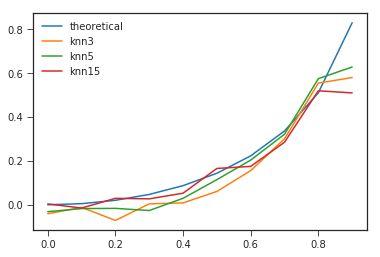

In [5]:
plt.plot(np.arange(0, 1, 0.1), tmis, label='theoretical')
# plt.plot(np.arange(0, 1, 0.1), cmis, label='dense ratio.')
plt.plot(np.arange(0, 1, 0.1), cmis_knn3, label='knn3')
plt.plot(np.arange(0, 1, 0.1), cmis_knn5, label='knn5')
plt.plot(np.arange(0, 1, 0.1), cmis_knn15, label='knn15')
plt.legend()

In [6]:
pre = [[   1,  0.5,    0],
       [ 0.5,    1, -0.5],
       [   0, -0.5,    1]]
diag = np.sqrt(np.diag(np.linalg.inv(pre)))
pre = pre * diag.reshape(-1, 1) * diag.reshape(1, -1)
cov = np.linalg.inv(pre)

tmi = calc_cmi(cov)[0][1]
cmis = []
cmis_knn3 = []
cmis_knn5 = []
cmis_knn15 = []
for n in tqdm.tqdm(np.arange(50, 550, 50)):
    X = scipy.stats.multivariate_normal(mean=[0, 0, 0], cov=cov).rvs(n)
    xz = X[:, np.arange(3) != 0]
    y = X[:, [0]]
    z = X[:, (np.arange(3) != 0) & (np.arange(3) != 1)]
#     cmis += [kliep.mutual_information(xz, y, sigma=0.8) - kliep.mutual_information(y, z, sigma=0.8)]
    cmis_knn3 += [mutual_information_knn(xz, y, k=3) - mutual_information_knn(y, z, k=3)]
    cmis_knn5 += [mutual_information_knn(xz, y, k=5) - mutual_information_knn(y, z, k=5)]
    cmis_knn15 += [mutual_information_knn(xz, y, k=15) - mutual_information_knn(y, z, k=15)]

100%|██████████| 10/10 [00:00<00:00, 28.45it/s]


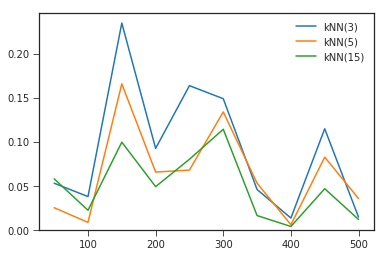

In [7]:
# plt.plot(np.arange(50, 550, 50), np.abs(np.array(cmis) - tmi), label='Proposed')
plt.plot(np.arange(50, 550, 50), np.abs(np.array(cmis_knn3) - tmi), label='kNN(3)')
plt.plot(np.arange(50, 550, 50), np.abs(np.array(cmis_knn5) - tmi), label='kNN(5)')
plt.plot(np.arange(50, 550, 50), np.abs(np.array(cmis_knn15) - tmi), label='kNN(15)')
plt.ylim([0, None])
plt.legend()

In [8]:
def heat_mi(X, ks=[3, 5, 15]):
    m = len(ks)
    f, axes = plt.subplots(1, m, figsize=[3 * m + 1, 3])
    n, d = X.shape
    for l, k in enumerate(ks):
        mis = np.eye(d)
        for i, j in [(i, j) for i in range(d) for j in range(d) if i != j]:
            x = X[:, [i]]
            y = X[:, [j]]
            mis[i, j] = mutual_information_knn(x, y, k=3)

        mis[mis < 0] = None
        mis[np.eye(d, dtype=bool)] = None
        sns.heatmap(mis, annot=True, ax=axes[l], center=0, cmap=palette, cbar=False)

def heat_cmi(X, ks=[3, 5, 15]):
    m = len(ks)
    f, axes = plt.subplots(1, m, figsize=[3 * m + 1, 3])
    n, d = X.shape
    for l, k in enumerate(ks):
        cmis = np.eye(d)
        for i, j in [(i, j) for i in range(d) for j in range(d) if i != j]:
            y = X[:, [j]]
            xz = X[:, np.arange(d) != j]
            z = X[:, (np.arange(d) != i) & (np.arange(d) != j)]
            cmis[i, j] = mutual_information_knn(xz, y, k=k) - mutual_information_knn(y, z, k=k)

        cmis[cmis < 0] = None
        cmis[np.eye(d, dtype=bool)] = None
        sns.heatmap(cmis, annot=True, ax=axes[l], center=0, cmap=palette, cbar=False)

## Gaussian mixture

In [9]:
cluster = (np.arange(1000) < 500).astype(int)
X1 = scipy.stats.multivariate_normal(mean=[-4, 0], cov=np.eye(2)).rvs(500)
X2 = scipy.stats.multivariate_normal(mean=[+4, 0], cov=np.eye(2)).rvs(500)
X = np.vstack([X1, X2])
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
X = np.hstack([X, cluster.reshape(-1, 1)])
X.shape

(1000, 3)

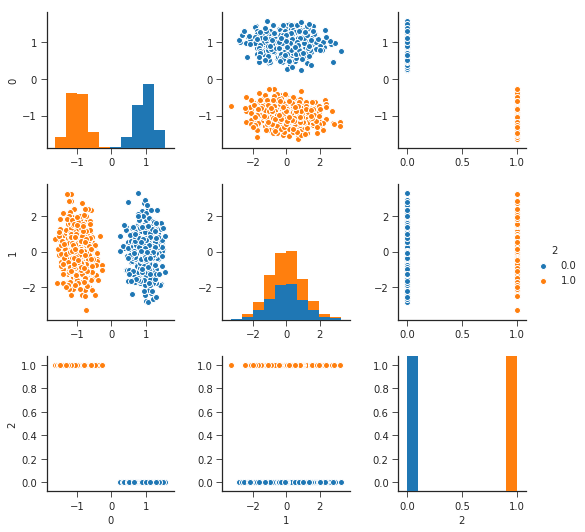

In [10]:
sns.pairplot(pd.DataFrame(X), hue=2)

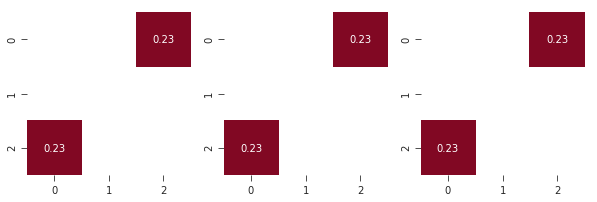

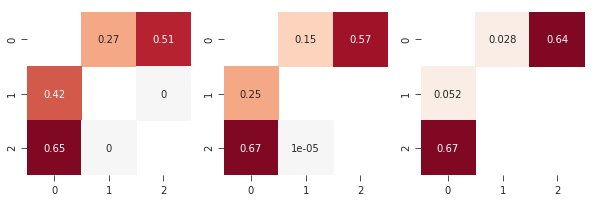

In [11]:
heat_mi(X)
heat_cmi(X)

## Gaussian mixture 2

In [12]:
cluster = np.arange(1500)
cluster[cluster < 500] = 0
cluster[(cluster >= 500) & (cluster < 1000)] = 1
cluster[cluster >= 1000] = 2
X1 = scipy.stats.multivariate_normal(mean=[-6, 0], cov=np.eye(2)).rvs(500)
X2 = scipy.stats.multivariate_normal(mean=[+6, 0], cov=np.eye(2)).rvs(500)
X3 = scipy.stats.multivariate_normal(mean=[ 0, 8], cov=np.eye(2)).rvs(500)
X = np.vstack([X1, X2, X3])
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
X = np.hstack([X, cluster.reshape(-1, 1)])
X.shape

(1500, 3)

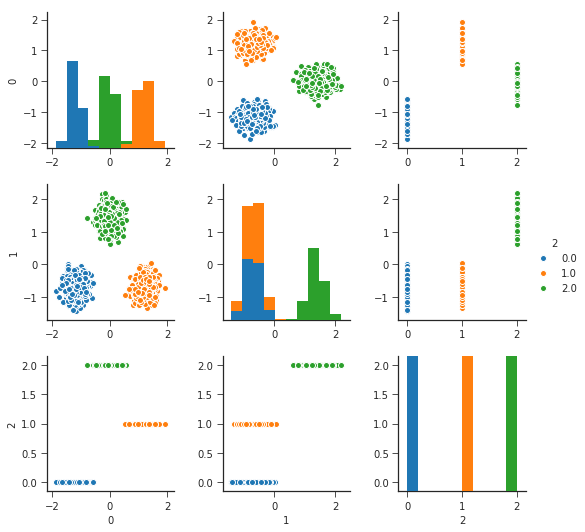

In [13]:
sns.pairplot(pd.DataFrame(X), hue=2)

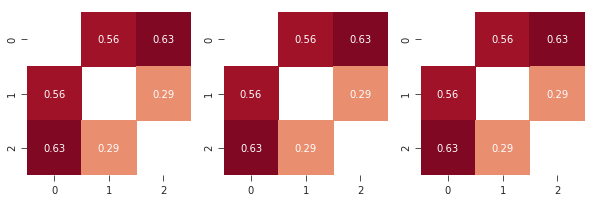

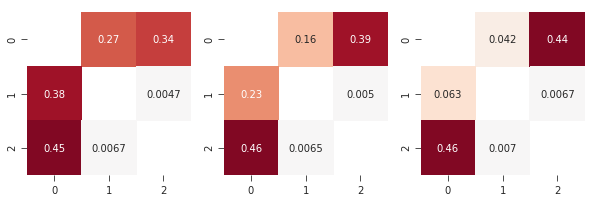

In [14]:
heat_mi(X)
heat_cmi(X)

## iris

In [15]:
data = sklearn.datasets.load_iris()
df = pd.DataFrame(data['data'], columns=list(data.feature_names))
df['class'] = data.target
df[:5]
X = df.values

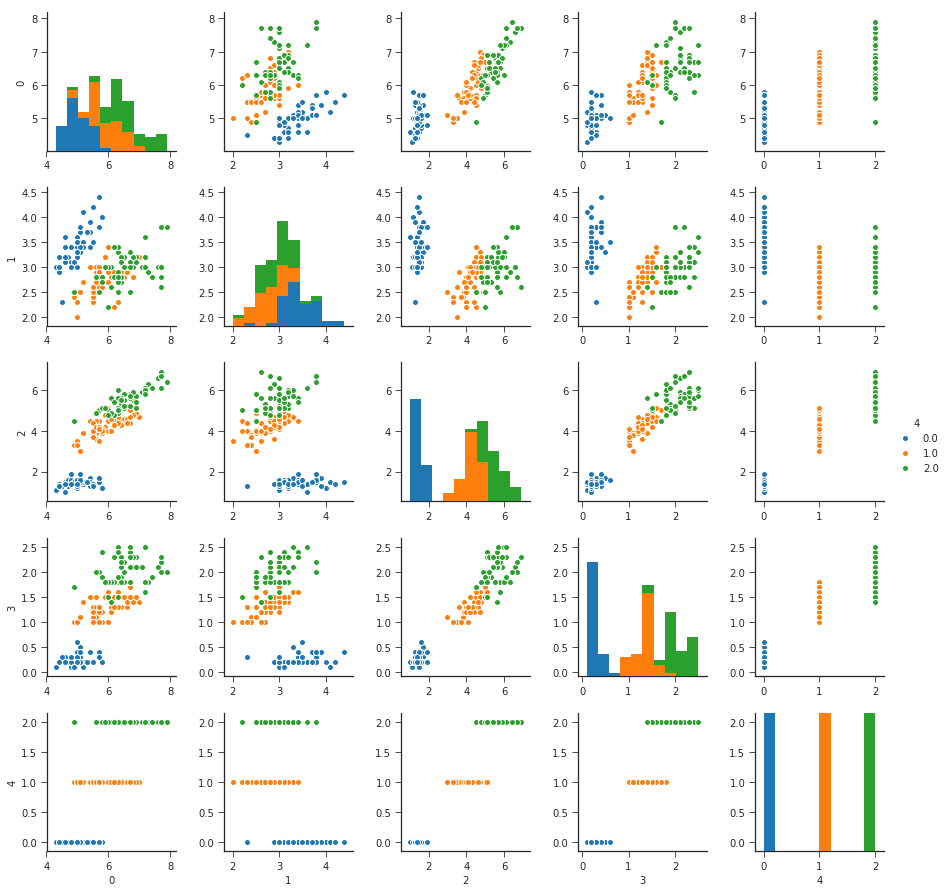

In [16]:
sns.pairplot(pd.DataFrame(X), hue=4)

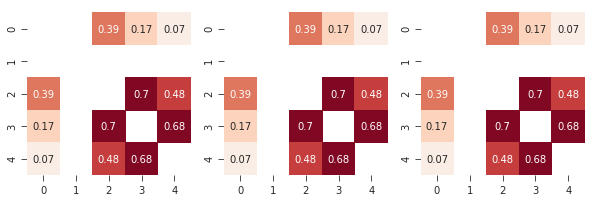

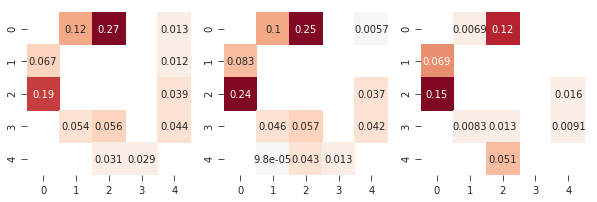

In [17]:
heat_mi(X)
heat_cmi(X)